In [210]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import chain
import random

In [211]:
padding = 3
with open('names.txt', 'r') as file:
    names = file.readlines()
names = ['.'*padding+name.strip()+'.' for name in names]
names[:3]

['...emma.', '...olivia.', '...ava.']

In [212]:
unique_char = set(list(chain(*names)))
length = len(unique_char)
chtoi = {i:en for en, i in enumerate(sorted(list(unique_char)))}
itoch = {v:k for k,v in chtoi.items()}
length

27

In [213]:
random.seed(42)
random.shuffle(names)
def build_dataset(names):
    Xs, Ys = [], []
    for word in names:
        for c1, c2, c3, c4 in zip(word, word[1:], word[2:], word[3:]):
            Xs.append([chtoi[c1],chtoi[c2],chtoi[c3]])
            Ys.append(chtoi[c4])
    Xs = torch.tensor(Xs)
    Ys = torch.tensor(Ys)
    print(Xs.shape, Ys.shape )
    return Xs, Ys
n1 = int(len(names)*.8)
n2 = int(len(names)*.9)
Xtra, Ytra = build_dataset(names[:n1])
Xval, Yval = build_dataset(names[n1:n2])
Xtes, Yes = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [236]:
embedding_dim = 5
batch_size = 128
hidden_dim = 100
hid_dim = [padding*embedding_dim, hidden_dim]
g = torch.Generator().manual_seed(2147483647)
lr = .2
embed = torch.rand((length, embedding_dim), requires_grad=True, generator=g)
print(f'{embed[Xtra].shape=}')

W1 = torch.randn(hid_dim[0],hid_dim[1], requires_grad=True, generator=g)
b1 = torch.randn(hid_dim[1], requires_grad=True, generator=g)
W2 = torch.randn(hid_dim[1],length, requires_grad=True, generator=g)
b2 = torch.randn(length, requires_grad=True, generator=g)
parameters = [embed, W1, b1, W2, b2]
print(f'{W1.shape=}, {b1.shape=}, {W2.shape=}, {b2.shape=}')

for i in range(200000):
    batch = torch.randint(0, Xtra.shape[0], (batch_size,))
    hidden = torch.tanh(embed[Xtra[batch]].view(-1, hid_dim[0]) @ W1 + b1)
    out = hidden @ W2 + b2
    loss = F.cross_entropy(out, torch.tensor(Ytra[batch])) 
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    if i % 1000 == 0:
        print(f'loss={loss.item()}')
    if  i == 100000:
        lr *= .1
    # if loss.item() < 2.1 and i > 500:
    #     print(f'loss={loss.item()} iteration={i}')
    #     break
print(f'loss={loss.item()}')

embed[Xtra].shape=torch.Size([182625, 3, 5])
W1.shape=torch.Size([15, 100]), b1.shape=torch.Size([100]), W2.shape=torch.Size([100, 27]), b2.shape=torch.Size([27])
loss=18.853958129882812


/tmp/ipykernel_17131/3777213684.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.cross_entropy(out, torch.tensor(Ytra[batch]))


loss=2.9169137477874756
loss=2.6290225982666016
loss=2.52078914642334
loss=2.492778778076172
loss=2.7559969425201416
loss=2.505089282989502
loss=2.628782272338867
loss=2.5692458152770996
loss=2.6872382164001465
loss=2.626154899597168
loss=2.4470059871673584
loss=2.5009701251983643
loss=2.269005537033081
loss=2.4711878299713135
loss=2.479494333267212
loss=2.357968807220459
loss=2.5544445514678955
loss=2.251105546951294
loss=2.517714500427246
loss=2.4097633361816406
loss=2.4227662086486816
loss=2.514840841293335
loss=2.513216495513916
loss=2.49706768989563
loss=2.3418824672698975
loss=2.34812068939209
loss=2.35732364654541
loss=2.3840808868408203
loss=2.38004732131958
loss=2.2459683418273926
loss=2.3329145908355713
loss=2.438859224319458
loss=2.850315809249878
loss=2.393937587738037
loss=2.4123728275299072
loss=2.442589282989502
loss=2.35341739654541
loss=2.4168763160705566
loss=2.4756481647491455
loss=2.4611353874206543
loss=2.3162946701049805
loss=2.05232572555542
loss=2.35089731216430

In [237]:
hidden = torch.tanh(embed[Xval].view(-1, hid_dim[0]) @ W1 + b1)
out = hidden @ W2 + b2
loss = F.cross_entropy(out, torch.tensor(Yval)) 
loss

/tmp/ipykernel_17131/322588635.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.cross_entropy(out, torch.tensor(Yval))


tensor(2.1942, grad_fn=<NllLossBackward0>)

In [238]:
embeddings = embed.detach().numpy()
embeddings.shape
embeddings[0,0]

0.5982463

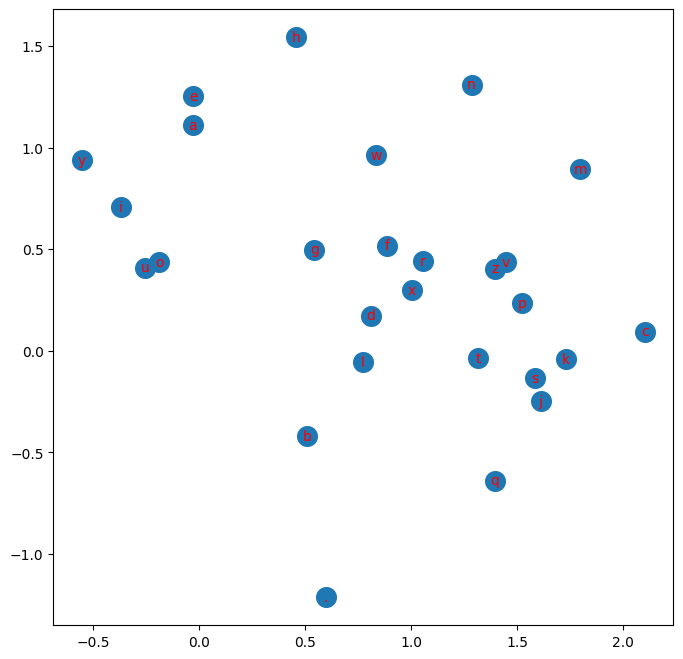

In [239]:
plt.figure(figsize=(8,8))
plt.scatter(embeddings[:,0], embeddings[:,1], s=200)
for i in range(length):
    plt.text(embeddings[i,0], embeddings[i,1], itoch[i], ha='center', va='center', color='red')

In [240]:
g = torch.Generator().manual_seed(2147483647 + 10)
@torch.no_grad()
def inference(n=10):
    new_names = []
    for i in range(n):
        name = ''
        sample = [0]*3
        while True:
            hidden = torch.tanh(embed[sample].view(-1, hid_dim[0]) @ W1 + b1)
            out = hidden @ W2 + b2 
            probs = F.softmax(out, dim=1)
            draw = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
            if draw == 0:
                break
            sample.pop(0)
            sample.append(draw)
            name += itoch[draw]
        new_names.append(name)
    return new_names
new_names = inference(20)
new_names

['pry',
 'jeon',
 'irah',
 'adum',
 'naiyah',
 'mud',
 'karysattilisigf',
 'eyper',
 'ova',
 'sarioman',
 'olsiaru',
 'macky',
 'ger',
 'milah',
 'brace',
 'roan',
 'naeksyogh',
 'abalynn',
 'jadilynn',
 'dren']